In [16]:
import pandas as pd
import numpy as np
import xarray as xr
import datacube
import geopandas as gpd
import math

from pyproj import Proj, transform

from dea_tools.plotting import rgb

%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb
from matplotlib import colors as mcolours
from dea_tools.plotting import display_map, rgb

In [17]:
def make_BSI(ds):
    BSI =  ((ds.swir1 + ds.red) - (ds.nir + ds.blue)) / ((ds.swir1 + ds.red) + (ds.nir + ds.blue))
        
    return BSI

def make_MBS(ds):
    BSI =  ((ds.swir1 - ds.swir2 - ds.nir )/ (ds.swir1 + ds.swir2 + ds.nir )) +0.5
        
    return BSI

In [18]:
# lets caluclate SSF:

def rescale_to_usgs_level1(dataset):
    #this rescales our ARD data to be in the same range as the USGS level 1 data product
    #this means the paper's constant can be used in place of normalisation 
    
    out_dataset = (dataset * 3.651) + 6486.1
    
    return out_dataset

#let's mask water

def mask_water(dataset, theshold=0.0):
    
    mndwi = (dataset.green - dataset.swir1)/(dataset.green +dataset.swir1)
    
    new_dataset = dataset.where(mndwi <= theshold)
    
    return new_dataset

def make_mf(dataset):
    mf = ((dataset.blue + dataset.green) - (dataset.nir + dataset.swir1))/ ((dataset.blue + dataset.green) + (dataset.nir + dataset.swir1))
    
    return mf

def make_ssf(dataset):
    mndwi = (dataset.green - dataset.swir1)/(dataset.green +dataset.swir1)
    
    MBI = ((dataset.swir1 - dataset.swir2 - dataset.nir)/(dataset.swir1 + dataset.swir2 + dataset.nir))+0.5
    
    EMBI = (MBI - mndwi - 0.5)/(MBI + mndwi + 0.5)
    
    return(1-EMBI)

# def make_MSAVI(dataset):

def make_vsf(dataset):
    
    ndvi = (dataset.nir - dataset.red)/(dataset.nir +dataset.red)
    
    msavi_numerator = 2 * dataset.nir + 1 - np.sqrt((2 * dataset.nir) ** 2 - 8 * (dataset.nir - dataset.red))
    MSAVI = msavi_numerator/2
    
    vsf = 1 - ndvi * MSAVI
    
    return vsf

def make_af(dataset):
    af = (dataset.nir - dataset.blue) / (dataset.nir + dataset.blue)
    
    return af

def normalise_f(index):
    #do normalisation for each index based on min-max in AOI extent
    
    Imin = index.min()
    Imax = index.max()
    normalised = (index - Imin)/( Imax - Imin)

    return normalised

def make_ASI(dataset):
    
    AF = normalise_f(make_af(dataset))
    VSF = normalise_f(make_vsf(dataset))
    SSF = normalise_f(make_ssf(dataset))
    MF = normalise_f(make_mf(dataset))

    ASI = AF * VSF * SSF * MF

    return(ASI)

def make_ASI_prime(dataset):
    AF = make_af(dataset)
    VSF = make_vsf(dataset)
    SSF = make_ssf(dataset)
    MF = make_mf(dataset)

    ASI = (AF +1) * VSF * SSF * (MF+1)

    return(ASI)

In [19]:
dc = datacube.Datacube(app="04_Loading_data")

In [20]:
# select a center point for an AOI 

#lake George
point_x, point_y = (-37.8080, 144.9553) #melbourne
# point_x, point_y = (-35.3104, 149.0429)#canberra
# point_x, point_y = (-33.1715, 138.0007) #point Pirie


lon = (point_x-0.6, point_x+0.6,)
lat = (point_y-0.6, point_y+0.6,)


#display area on map
display_map(lat, lon)

In [21]:
#load the datasets
#start with wofs frequency

# Set query and load data


query = {
    'y': lon,
    'x': lat,
}

# Load DEA Land Cover data from the datacube
lst_8 = dc.load(product='ga_ls8c_nbart_gm_cyear_3',
             output_crs='EPSG:3577',
             # measurements=['blue'],
             time=("2015-01-01", "2015-12-31"),
             resolution=(30, -30),
             **query)


In [22]:
#lets make the index

#first mask water

water_masked_lst8 = mask_water(lst_8.astype('int64'), theshold=(-0.1))

In [23]:
water_masked_lst8

<xarray.Dataset>
Dimensions:      (time: 1, y: 4749, x: 3974)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999999
  * y            (y) float64 -4.263e+06 -4.263e+06 ... -4.12e+06 -4.12e+06
  * x            (x) float64 1.206e+06 1.206e+06 ... 1.087e+06 1.087e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) float64 370.0 399.0 419.0 ... 278.0 313.0 321.0
    green        (time, y, x) float64 684.0 705.0 739.0 ... 390.0 441.0 443.0
    red          (time, y, x) float64 602.0 643.0 705.0 ... 427.0 505.0 509.0
    nir          (time, y, x) float64 3.637e+03 3.543e+03 ... 1.833e+03
    swir1        (time, y, x) float64 2.55e+03 2.488e+03 ... 1.637e+03 1.596e+03
    swir2        (time, y, x) float64 1.303e+03 1.297e+03 ... 1.007e+03
    sdev         (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    edev         (time, y, x) float64 645.0 709.0 608.0 ... 381.0 235.0 280.0
    bcdev        (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    count        (time, y, x) float64 5.0 6.0 6.0 6.0 ... 17.0 17.0 16.0 16.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [24]:
# lst_8_mads = xr.Dataset(data_vars=dict(
#         sdev=(['time','y','x'], lst_8['sdev'].data),
#         edev=(['time','y','x'], lst_8['edev'].data),
#         bcdev=(['time','y','x'], lst_8['bcdev'].data)),
#         coords = lst_8.coords,
#         attrs= lst_8.attrs)


In [25]:
# lst_8_mads.bcdev.plot()

ASI = f(AF) × f(VSF) × f(SSF) × f(MF)

MF = (ρBlue + ρGreen) − (ρNIR + ρSWIR1)
(ρBlue + ρGreen) + (ρNIR + ρSWIR1) 


In [26]:
# make ASI 
ASI_data = make_ASI(water_masked_lst8)

In [31]:
# make ASI 
ASIprime_data = make_ASI_prime(water_masked_lst8)

Text(0.5, 1.0, 'ASI prime')

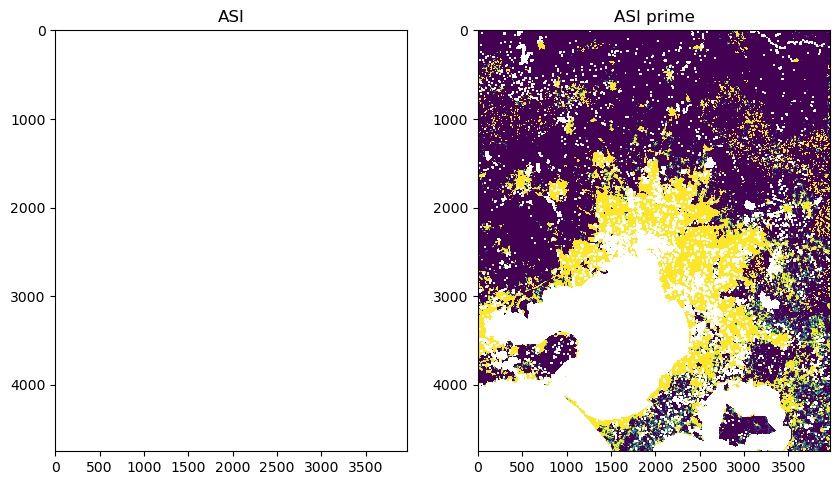

In [32]:
# Create just a figure and only one subplot
# Create two subplots and unpack the output array immediately
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.flip(ASI_data.isel(time=0)))
ax[1].imshow(np.flip(ASIprime_data.isel(time=0)), vmin=0, vmax=0.04)
ax[0].set_title('ASI')
ax[1].set_title('ASI prime')



In [29]:
# # View a red, green, blue (true colour) image of the first timestep
# rgb(lst_8_mads, bands=["sdev", "edev", "bcdev"])

In [30]:
lst_8_mads.bcdev.plot(vmax=0.35)

NameError: name 'lst_8_mads' is not defined

In [ ]:
(lst_8_mads.edev/10000).plot(vmax=0.35)

In [ ]:
lst_8_mads.sdev.plot()

In [ ]:
rgb(lst_8, bands=["red", "green", "blue"])

In [ ]:
test_equation2 = ((lst_8_mads.sdev - lst_8_mads.sdev) - (lst_8_mads.bcdev -  lst_8_mads.edev))/((lst_8_mads.bcdev - lst_8_mads.edev) + (lst_8_mads.sdev -  lst_8_mads.edev))
test_equation2.plot()

In [ ]:
test_equation = (lst_8.bcdev + (lst_8.edev/10000)) * (make_BSI(lst_8))
test_equation.plot()

In [ ]:
test_equation = abs((lst_8.bcdev + (lst_8.edev/10000)) * (make_BSI(lst_8)))
test_equation.plot()
#this one is moderatly okay

In [ ]:
maskable= test_equation < 0.01

In [ ]:
maskable.plot()

In [ ]:
masked_asi = ASI_data.where(maskable)
masked_asi.plot()

In [ ]:
from datacube.utils.cog import write_cog

write_cog(geo_im=masked_asi,
          fname='port_pirie_masked_ASI.tif',
          overwrite=True)

In [ ]:
mask_able = bcd_ed < -0.15
mask_able.plot()

In [ ]:
mask_mads = Mads_index > 0.8

In [ ]:
mask_mads.plot()